simplified version with only two neurons (one for providing delay feedback)
adapated from HMM_GA_01
20200414 created by CKC

In [1]:
from timeit import default_timer as timer
import numpy as np
from random import gauss
from math import sqrt
import matplotlib as mpl
mpl.use('nbagg')
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# using numpy's histogram2d to calculate the mutual information between two sequences
def mi_quick(a,b,d,bn=25):
    if d>0: xy,_,_ = np.histogram2d(a[d:],b[:-d],bn)
    elif d<0: xy,_,_ = np.histogram2d(a[:d],b[-d:],bn)
    else: xy,_,_ = np.histogram2d(a,b,bn)
    xy /= np.sum(xy)
    px = [np.array([max(x,1e-100) for x in np.sum(xy,axis=0)])]
    py = np.transpose([[max(x,1e-100) for x in np.sum(xy,axis=1)]])
    nxy = (xy/px)/py
    nxy[nxy==0] = 1e-100
    return np.sum(xy*np.log2(nxy))

In [3]:
def rescale(x,xmax,xmin):
    rx = np.zeros(len(x))
    xminval = np.min(x)
    xmaxval = np.max(x)
    for i in range(len(x)):
        rx[i] = (x[i]-xminval)/(xmaxval-xminval)*(xmax-xmin)+xmin
    return rx

In [4]:
def sigmoid(x):
    #print(x,1./(np.exp(-x)))
    return(1./(1+np.exp(-x)))
    #return(x)

In [5]:
def march_sim(input):
    nstep = len(input)
    output = np.zeros(nstep)
    for i in range(N):
        y[i]= 0.0
        
    for k in range(nstep):
        for i in range(N):
            ssum[i] = 0.0
            for j in range(N):
                o[j] = (y[j]+theta[j])
                ssum[i] = ssum[i] + w[i,j]*o[j]
            dyi = (-y[i] + ssum[i] + w_in[i]*input[k])/tau[i]*dt
            y[i] = y[i] + dyi
        ssum1 = 0
        for i in range(N):
            ssum1 = ssum1 + w_o[i]*o[i]
        #output[k] = 2*sigmoid(ssum1)-1
        output[k] = y[0]
    return(output)

In [6]:
def march_sim_ori(input):
    nstep = len(input)
    output = np.zeros(nstep)
    #print(N,nstep)
    for i in range(N):
        y[i]= 0.0
        
    for k in range(nstep):
        for i in range(N):
            ssum[i] = 0.0
            for j in range(N):
                #o[j] = sigmoid(y[j]+theta[j])
                o[j] = (y[j]+theta[j])
                ssum[i] = ssum[i] + w[i,j]*o[j]
            dyi = (-y[i] + ssum[i] + w_in[i]*input[k])*(dt/tau[0])
            print(k,dyi)
            y[i] = y[i] + dyi
        ssum1 = 0
        for i in range(N):
            ssum1 = ssum1 + w_o[i]*o[i]
        #output[k] = 2*sigmoid(ssum1)-1
        #output[k] = 2*(ssum1)-1
        output[k] = y[0]
    return(output)

In [7]:
# generate the HMM signal

G_HMM = 10/2/2/2/2; 
D_HMM = 2.7e6;     #dynamical range
nstep = 10000
dt = 0.02

# HMM model parameters
#    G_HMM = 4; 
#    D_HMM = 2700000;     #dynamical range
omega =G_HMM/2.12;   # omega = G/(2w)=1.06; follow Bialek's overdamped dynamics/ 2015PNAS

# generate the stochastic sequence in x
x = np.zeros(nstep)
v = np.zeros(nstep)
x[0] = 0.0
v[0] = 0.0
for i in range(1,nstep):
        x[i] = x[i-1] + v[i-1]*dt
        v[i] = (1-G_HMM*dt)*v[i-1]-omega**2*x[i-1]*dt + gauss(0,1)*np.sqrt(D_HMM*dt)


In [8]:
# NDG filter

n1 = 30 # delay
y  = np.zeros(nstep)

K = 30.

y[0] = 0.0
alpha = 60.
for i in range(1,n1):
    dy = (-alpha*y[i-1])*dt
    y[i] = y[i-1] + dy

for i in range(n1,nstep):
    dy = (-alpha*y[i-1]+K*(x[i] - y[i-n1]))*dt
    y[i] = y[i-1] + dy

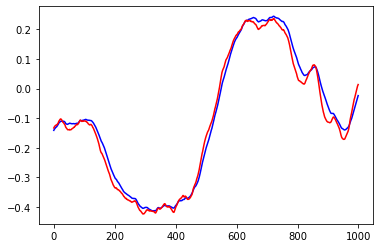

In [9]:
rx = rescale(x,1,-1)
ry = rescale(y,1,-1)
plt.plot(rx[1000:2000],'b')
plt.plot(ry[1000:2000],'r')

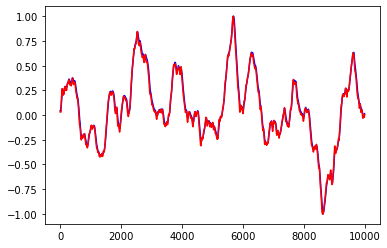

In [10]:
plt.plot(rx,'b')
plt.plot(ry,'r')

In [11]:
dms = range(-99,100)
mi_xx = [mi_quick(x,x,d) for d in dms]  
mi_xy = [mi_quick(x,y,d) for d in dms]

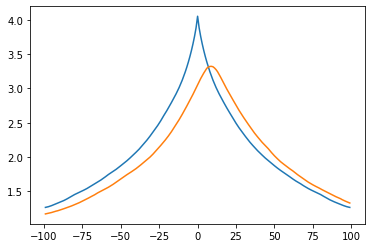

In [12]:
plt.plot(dms,mi_xx)
plt.plot(dms,mi_xy)

In [13]:
# for neurons

N = 2
ssum = np.zeros(N)
o = np.zeros(N)
y = np.zeros(N)

w = np.zeros((N,N))
w_o = np.zeros(N)
w_in = np.zeros(N)
tau = np.zeros(N)
theta = np.zeros(N)

# no self connection
w[0,0] = 0
w[1,1] = 0

w[0,1] = 1
w[1,0] = -1

w_in[0] = 1.5 # input strength of signal
w_in[1] = 0.0 # no input to inter-neuron

tau[0] = 0.1  # time scale of output cell
tau[1] = 0.5  # time scale of inter-neuron

theta[0] = 0.0
theta[1] = 0.0

w_o[0] = 1
w_o[0] = 0


#for i in range(N):
#    tau[i]   = np.random.uniform(low=0.0, high=1.0)
#    theta[i] = np.random.uniform(low=0.0, high=1.0)
#    y [i] = np.random.uniform(low=0.0, high=1.0)
    #if i == N-1: # output neuron id = N-1
    #w_o[i] = np.random.uniform(low=-1.0, high=1.0)
    #if i == 0:  # input neuron id = 0
    #w_in[i] = np.random.uniform(low=-1.0, high=1.0)
    
o  = march_sim(rx)
ro = rescale(o,1,-1) 
#plt.plot(rx)
#plt.plot(ro)

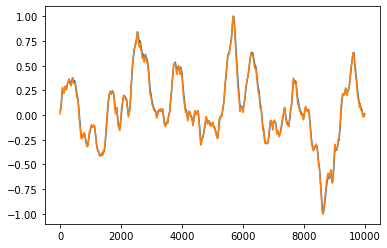

In [14]:
plt.plot(rx)
plt.plot(ro)

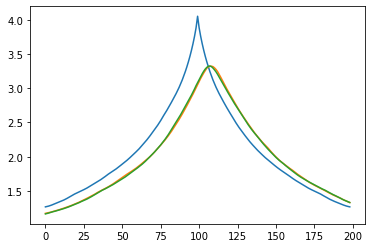

In [15]:
mi_xo = [mi_quick(x,o,d) for d in dms]
plt.plot(mi_xx)
plt.plot(mi_xy)
plt.plot(mi_xo)

In [16]:
def NGD_pop_fitness_sim(pop):
    # only three parameters
    fitness = np.zeros(len(pop))
    for l in range(len(pop)):
        #print(l)

        for k in range(len(pop[l])):
            w_in[0] = pop[l][0]
            tau[0]  = pop[l][1] 
            tau[1]  = pop[l][2] 
            
        o = march_sim(rx)
        #plt.plot(o)
        #mi_xo  = [mi_quick(x,o,d) for d in dms]
        ro = ro = rescale(o,1,-1)
        ssum = 0.0
        for i in range(len(ro)):
            ssum = ssum +(ro[i]-ry[i])**2
        score1 = 1./(ssum+ 0.00001)
        
        mi_xo  = [mi_quick(x,o,d) for d in dms]
        score2 = np.sign(np.argmax(mi_xo)-100)*np.max(mi_xo)
        fitness[l] = score1*score2
                       
        #print(score1,score2)
        #print(l,fitness[l])
    return(fitness)

In [17]:
theta

array([0., 0.])

In [18]:
def get_output_sim(para):
    w_in[0] = para[0]
    tau[0]  = para[1]
    tau[1]  = para[2]
       
    return(march_sim(rx))

In [19]:
def showpara_sim(para):
    #print(para)
    for l in range(len(para)):
        w_in[0] = pop[l][0]
        tau[0]  = pop[l][1] 
        tau[1]  = pop[l][2]

    print('w')
    print(w)
    print('W_in')
    print(w_in)
    print('W_o')
    print(w_o)
    print('tau')
    print(tau)
    print('theta')
    print(theta)
    return()

In [20]:
import numpy

def cal_pop_fitness(equation_inputs, pop):
    # Calculating the fitness value of each solution in the current population.
    # The fitness function caulcuates the sum of products between each input and its corresponding weight.
    fitness = numpy.sum(pop*equation_inputs, axis=1)
    return fitness

def select_mating_pool(pop, fitness, num_parents):
    # Selecting the best individuals in the current generation as parents for producing the offspring of the next generation.
    parents = numpy.empty((num_parents, pop.shape[1]))
    for parent_num in range(num_parents):
        max_fitness_idx = numpy.where(fitness == numpy.max(fitness))
        max_fitness_idx = max_fitness_idx[0][0]
        parents[parent_num, :] = pop[max_fitness_idx, :]
        fitness[max_fitness_idx] = -99999999999
    return parents

def crossover(parents, offspring_size):
    offspring = numpy.empty(offspring_size)
    # The point at which crossover takes place between two parents. Usually it is at the center.
    crossover_point = numpy.uint8(offspring_size[1]/2)

    for k in range(offspring_size[0]):
        # Index of the first parent to mate.
        parent1_idx = k%parents.shape[0]
        # Index of the second parent to mate.
        parent2_idx = (k+1)%parents.shape[0]
        # The new offspring will have its first half of its genes taken from the first parent.
        offspring[k, 0:crossover_point] = parents[parent1_idx, 0:crossover_point]
        # The new offspring will have its second half of its genes taken from the second parent.
        offspring[k, crossover_point:] = parents[parent2_idx, crossover_point:]
    return offspring

def mutation(offspring_crossover):
    # Mutation changes a single gene in each offspring randomly.
    for idx in range(offspring_crossover.shape[0]):
        # The random value to be added to the gene.
        random_value = numpy.random.uniform(0.1, 1.0, 1)
        offspring_crossover[idx, 2] = offspring_crossover[idx, 2] + random_value
    return offspring_crossover

In [21]:
# Number of the weights we are looking to optimize.
num_weights = 3
sol_per_pop = 40
num_parents_mating = 4

# Defining the population size.
pop_size = (sol_per_pop,num_weights) # The population will have sol_per_pop chromosome where each chromosome has num_weights genes.
#Creating the initial population.
new_population = np.random.uniform(low=0.1, high=1.0, size=pop_size)
#print(new_population)

In [22]:

"""
Genetic algorithm parameters:
    Mating pool size
    Population size
"""

# Defining the population size.
pop_size = (sol_per_pop,num_weights) # The population will have sol_per_pop chromosome where each 
                                     # chromosome has num_weights genes.
#Creating the initial population.
new_population = np.random.uniform(low=0.1, high=1.0, size=pop_size)
#print(new_population)

In [28]:
print(new_population)

[[0.75128323 0.15835308 0.47374773]
 [0.16747886 0.16262292 0.44193689]
 [0.75128323 0.16262292 0.54251315]
 [0.75128323 0.16262292 0.54674302]
 [0.75128323 0.16262292 1.29492665]
 [0.16747886 0.16262292 1.12766104]
 [0.75128323 0.16262292 1.21257801]
 [0.75128323 0.15835308 1.07394547]
 [0.75128323 0.16262292 1.03580013]
 [0.16747886 0.16262292 1.09557627]
 [0.75128323 0.16262292 0.78227428]
 [0.75128323 0.15835308 1.23879577]
 [0.75128323 0.16262292 0.7616105 ]
 [0.16747886 0.16262292 0.87063283]
 [0.75128323 0.16262292 1.08550759]
 [0.75128323 0.15835308 0.58206381]
 [0.75128323 0.16262292 0.82711406]
 [0.16747886 0.16262292 0.99421518]
 [0.75128323 0.16262292 1.45967368]
 [0.75128323 0.15835308 0.82819529]
 [0.75128323 0.16262292 0.7431524 ]
 [0.16747886 0.16262292 1.06993241]
 [0.75128323 0.16262292 0.79247049]
 [0.75128323 0.15835308 0.70833692]
 [0.75128323 0.16262292 0.85058549]
 [0.16747886 0.16262292 1.27463449]
 [0.75128323 0.16262292 0.8981752 ]
 [0.75128323 0.15835308 1.31

fitness = cal_pop_fitness(new_population)
print(fitness)

plt.plot(fitness)
parents = ga.select_mating_pool(new_population, fitness, 
                                      num_parents_mating)

cal_pop_fitness(parents)

In [23]:
num_generations = 20
start = timer()
nprint =1
for generation in range(num_generations):
    #print(generation)
    # Measing the fitness of each chromosome in the population.
    fitness = NGD_pop_fitness_sim(new_population)
    #print(fitness)
    # Selecting the best parents in the population for mating.
    parents =  select_mating_pool(new_population, fitness, 
                                      num_parents_mating)
    if generation%nprint ==0:
        end = timer()
        etime = end-start
        print(str(generation) + ' / ' + str(num_generations),
              etime,'will finish in about ',
              (num_generations-generation)*etime/60/nprint,' min')
        print(NGD_pop_fitness_sim(parents))
        start = timer()

    # Generating next generation using crossover.
    offspring_crossover =  crossover(parents,
                                       offspring_size=(pop_size[0]-parents.shape[0], num_weights))

    # Adding some variations to the offsrping using mutation.
    offspring_mutation =  mutation(offspring_crossover)

    # Creating the new population based on the parents and offspring.
    new_population[0:parents.shape[0], :] = parents
    new_population[parents.shape[0]:, :] = offspring_mutation

    # The best result in the current iteration.
    #print("Best result : ", np.max(np.sum(new_population*equation_inputs, axis=1)))

# Getting the best solution after iterating finishing all generations.

#At first, the fitness is calculated for each solution in the final generation.

fitness = NGD_pop_fitness_sim(new_population)

# Then return the index of that solution corresponding to the best fitness.
best_match_idx = np.where(fitness == np.max(fitness))

print("Best solution : ", new_population[best_match_idx, :])
print("Best solution fitness : ", fitness[best_match_idx])

best_para=new_population[best_match_idx, :][0][0]


0 / 20 7.572466723000616 will finish in about  2.524155574333539  min
[1.69250592 1.58732033 0.84764391 0.47141246]
1 / 20 7.607196853999994 will finish in about  2.4089456704333316  min
[1.69250592 1.58732033 1.45426068 1.40415769]
2 / 20 7.610570690999339 will finish in about  2.2831712072998016  min
[1.69250592 1.58732033 1.47053982 1.45426068]
3 / 20 7.57515102600064 will finish in about  2.146292790700181  min
[1.69250592 1.58732033 1.47053982 1.45426068]
4 / 20 7.596427708000192 will finish in about  2.0257140554667177  min
[1.69250592 1.58732033 1.47316191 1.47053982]
5 / 20 7.623919138999554 will finish in about  1.9059797847498885  min
[1.69250592 1.58732033 1.53779338 1.52642036]
6 / 20 8.032000865000555 will finish in about  1.874133535166796  min
[1.69250592 1.58732033 1.53779338 1.52642036]
7 / 20 7.910530989999643 will finish in about  1.7139483811665892  min
[1.69250592 1.58732033 1.53779338 1.52642036]
8 / 20 7.577966898999875 will finish in about  1.515593379799975  mi

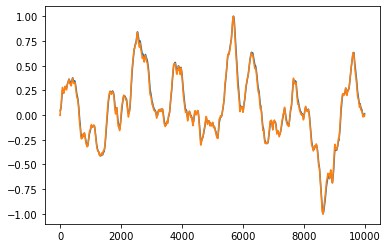

In [24]:
z=get_output_sim(best_para)
plt.plot(rx)
oz = rescale(o,1,-1)
plt.plot(oz)

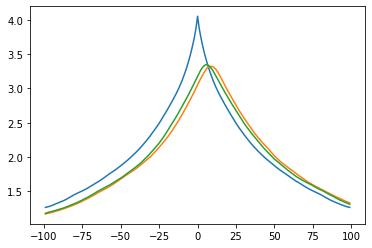

In [25]:
mi_xz = [mi_quick(x,z,d) for d in dms]
plt.plot(dms,mi_xx)
plt.plot(dms,mi_xy)
plt.plot(dms,mi_xz)

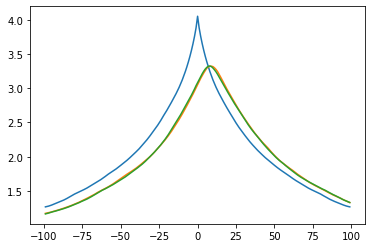

In [26]:
plt.plot(dms,mi_xx)
plt.plot(dms,mi_xy)
plt.plot(dms,mi_xo)

In [27]:
best_para

array([0.75128323, 0.15835308, 0.47374773])